# 1. Setup & Data Loading

### 1.1 Imports

In [1]:
# 1.1 Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1.2 Load data

In [3]:
# 1.2 Load data
csv_path = r"C:\Springboard\Supervised Learning\14.3 Decision Trees\1613148038_Springboard_Decision_Tree_Specialty_Coffee_Case_Study_28012021_2_\data\RRDinerCoffeeData.csv"
coffeeData = pd.read_csv(csv_path)

display(coffeeData.head(10))
print("Shape:", coffeeData.shape)
coffeeData.info()
display(coffeeData.describe(include=[np.number]).T)
display(coffeeData.describe(include=['object']).T)


,Age,Gender,num_coffeeBags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
0,36,Female,0,24,73,42789,0.003168,0,1.0
1,24,Male,0,44,164,74035,0.520906,0,NaN
2,24,Male,0,39,119,30563,0.916005,1,1.0
3,20,Male,0,30,107,13166,0.932098,1,NaN
4,24,Female,0,20,36,14244,0.965881,0,1.0
5,20,female,0,23,28,14293,1.036346,1,1.0
6,34,Female,0,55,202,91035,1.134851,0,1.0
7,24,Female,0,20,34,17425,1.193188,0,NaN
8,27,Male,0,49,145,43716,1.327208,0,1.0
9,16,F,0,55,176,4701,1.445575,1,1.0


Shape: (702, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      702 non-null    int64  
 1   Gender                   702 non-null    object 
 2   num_coffeeBags_per_year  702 non-null    int64  
 3   spent_week               702 non-null    int64  
 4   spent_month              702 non-null    int64  
 5   SlrAY                    702 non-null    int64  
 6   Distance                 702 non-null    float64
 7   Online                   702 non-null    int64  
 8   Decision                 474 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 49.5+ KB


,count,mean,std,min,25%,50%,75%,max
Age,702.0,34.243590,13.927945,16.000000,23.000000,28.000000,46.000000,90.000000
num_coffeeBags_per_year,702.0,2.710826,1.593629,0.000000,1.000000,3.000000,4.000000,5.000000
spent_week,702.0,32.853276,15.731878,0.000000,24.250000,36.000000,43.000000,62.000000
spent_month,702.0,107.923077,55.348485,0.000000,62.000000,113.500000,150.750000,210.000000
SlrAY,702.0,43819.843305,26192.626943,1617.000000,22812.250000,41975.000000,60223.000000,182058.000000
Distance,702.0,4.559186,3.116275,0.003168,1.877812,4.196167,6.712022,10.986203
Online,702.0,0.531339,0.499373,0.000000,0.000000,1.000000,1.000000,1.000000
Decision,474.0,0.639241,0.480728,0.000000,0.000000,1.000000,1.000000,1.000000


,count,unique,top,freq
Gender,702,9,Male,355


### 1.3 Column names

In [4]:
# 1.3 Column names
list(coffeeData.columns)

['Age',
 'Gender',
 'num_coffeeBags_per_year',
 'spent_week',
 'spent_month',
 'SlrAY',
 'Distance',
 'Online',
 'Decision']

# 2. Cleaning & Exploration

### 2.1 Clean / normalize

In [5]:
# 2.1 Clean / normalize
def _norm_gender(v):
    if pd.isna(v): return np.nan
    s = str(v).strip().lower()
    if s in ['f','female','woman','lady']: return 'Female'
    if s in ['m','male','man','gentleman']: return 'Male'
    return str(v).title()

if 'Gender' in coffeeData.columns:
    coffeeData['Gender'] = coffeeData['Gender'].apply(_norm_gender)

def _map_decision(x):
    if pd.isna(x): return np.nan
    try:
        return 'YES' if float(x) == 1.0 else 'NO'
    except:
        s = str(x).strip().upper()
        if s in ['YES','NO']: return s
        return np.nan

if 'Decision' in coffeeData.columns:
    coffeeData['Decision'] = coffeeData['Decision'].apply(_map_decision)

# Optional alias if present
if 'spent_week' in coffeeData.columns and 'spent_per_week' not in coffeeData.columns:
    coffeeData['spent_per_week'] = coffeeData['spent_week']

print("Decision counts (non-null):")
if 'Decision' in coffeeData.columns:
    print(coffeeData['Decision'].value_counts(dropna=True))


Decision counts (non-null):
Decision
YES    303
NO     171
Name: count, dtype: int64


### 2.2 Split labeled/unlabeled rows

In [6]:
# 2.2 Split labeled/unlabeled rows
NoPrediction = coffeeData.dropna(subset=['Decision']).copy()
Prediction   = coffeeData[coffeeData['Decision'].isna()].copy()

print('NoPrediction:', NoPrediction.shape, '| Prediction:', Prediction.shape)


NoPrediction: (474, 10) | Prediction: (228, 10)


### 2.3 EDA plots (matplotlib only)

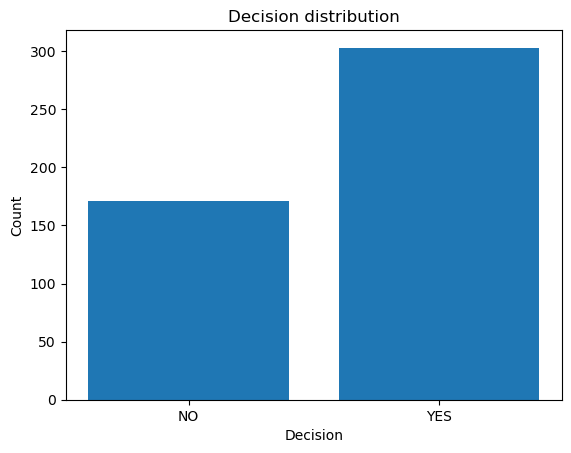

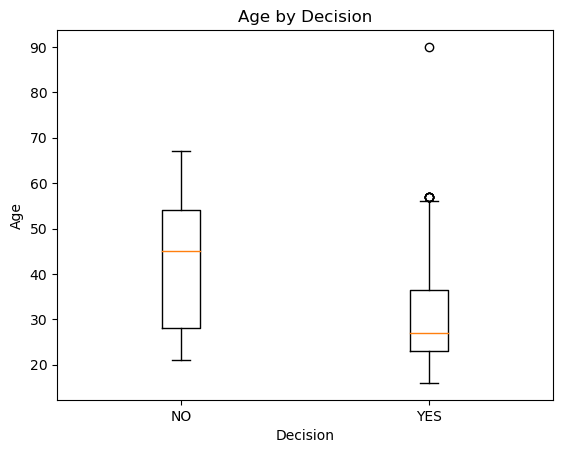

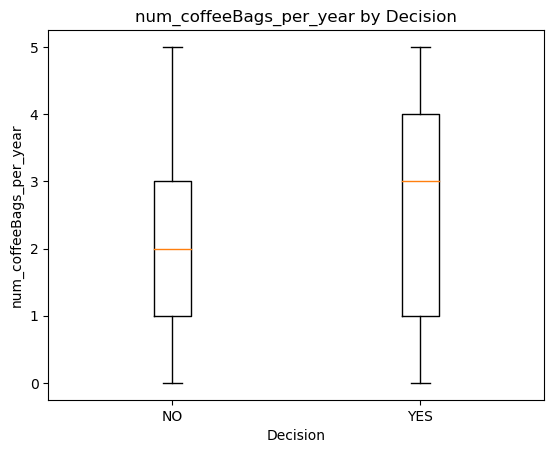

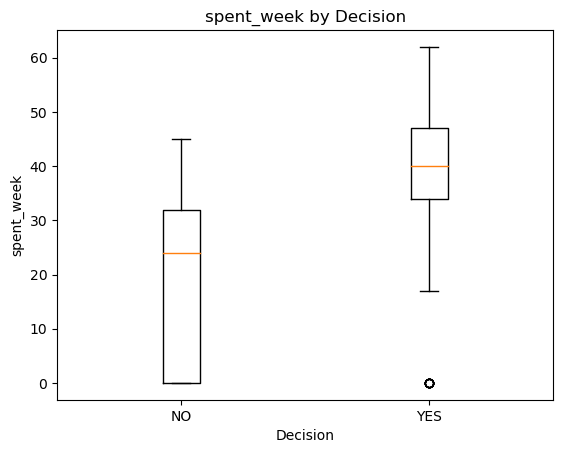

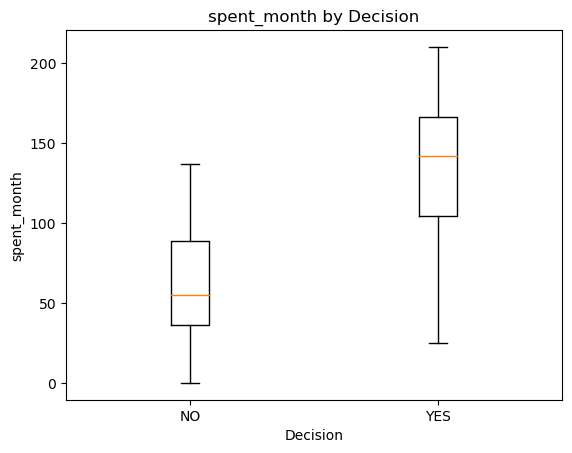

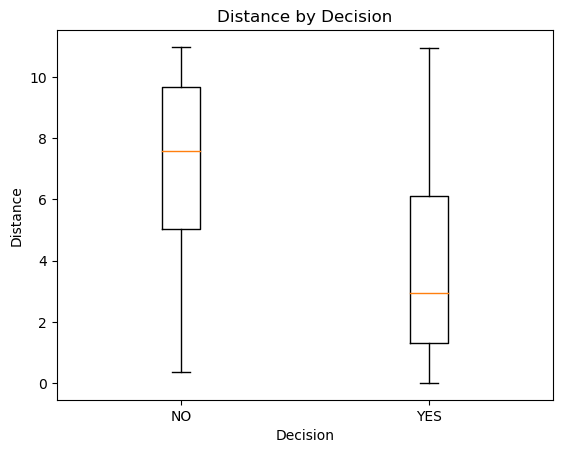

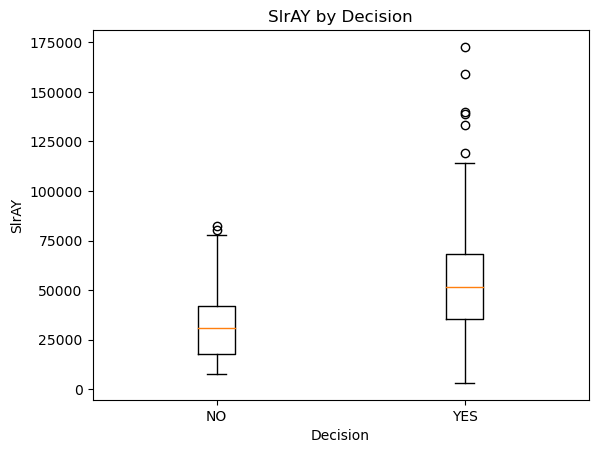

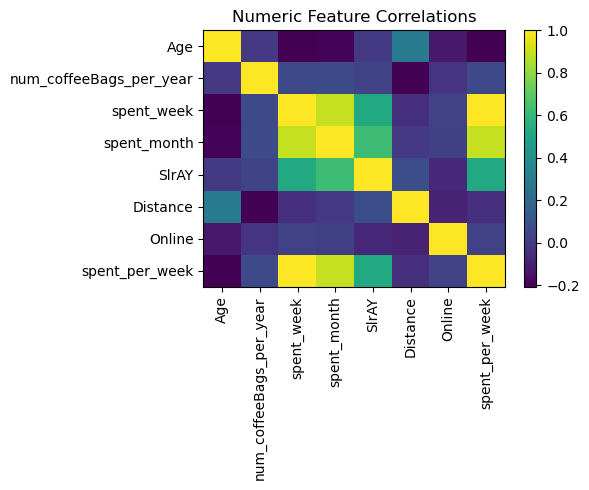

In [7]:
# 2.3 EDA plots (matplotlib)
# Class balance
if 'Decision' in NoPrediction.columns:
    vals = NoPrediction['Decision'].value_counts().sort_index()
    plt.figure()
    plt.bar(vals.index, vals.values)
    plt.title('Decision distribution')
    plt.xlabel('Decision')
    plt.ylabel('Count')
    plt.show()

# Boxplots by Decision for numeric columns (if present)
def boxplot_by_decision(df, feature, title=None):
    groups = [df[df['Decision']==lab][feature].dropna().values
              for lab in sorted(df['Decision'].dropna().unique())]
    if len(groups) >= 1 and all(len(g)>0 for g in groups):
        plt.figure()
        plt.boxplot(groups, labels=sorted(df['Decision'].dropna().unique()))
        plt.title(title or f'{feature} by Decision')
        plt.xlabel('Decision')
        plt.ylabel(feature)
        plt.show()

for col in ['Age','num_coffeeBags_per_year','spent_week','spent_month','Distance','SlrAY']:
    if col in NoPrediction.columns:
        boxplot_by_decision(NoPrediction, col)

# Correlation heatmap (numeric cols only)
num_cols = NoPrediction.select_dtypes(include='number').columns.tolist()
if len(num_cols) >= 2:
    corr = NoPrediction[num_cols].corr()
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr, aspect='auto')
    plt.colorbar(im)
    plt.title('Numeric Feature Correlations')
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()


# 3. Features & Preprocessing

### 3.1 Feature selection (robust)

In [8]:
# 3.1 Feature selection (robust)
target = 'Decision'
cat = [c for c in ['Gender','Online'] if c in NoPrediction.columns]
num = [c for c in ['Age','num_coffeeBags_per_year','spent_week','spent_month','SlrAY','Distance'] if c in NoPrediction.columns]

# ensure Online is numeric if present
if 'Online' in cat:
    NoPrediction['Online'] = pd.to_numeric(NoPrediction['Online'], errors='coerce').fillna(0).astype(int)
    if len(Prediction) > 0:
        Prediction['Online'] = pd.to_numeric(Prediction['Online'], errors='coerce').fillna(0).astype(int)

X = NoPrediction[cat + num].copy()
y = NoPrediction[target].copy()
print('Features used:', cat + num)


Features used: ['Gender', 'Online', 'Age', 'num_coffeeBags_per_year', 'spent_week', 'spent_month', 'SlrAY', 'Distance']


### 3.2 Train/test split + preprocessing

In [9]:
# 3.2 Train/test split + preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat)],
    remainder='passthrough'
)


# 4. Decision Trees

### 4.1 entr_model (entropy) — fit, predict, series

In [10]:
# 4.1 entr_model (entropy)
entr_model = Pipeline([
    ('prep', preprocess),
    ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42))
])

entr_model.fit(X_train, y_train)
y_pred_entr = entr_model.predict(X_test)
y_pred_entr = pd.Series(y_pred_entr, index=X_test.index, name='entr_pred')

entr_model


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender', 'Online'])])),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        random_state=42))])

### 4.2 gini_model — fit, predict, series, inspect

In [11]:
# 4.2 gini_model
gini_model = Pipeline([
    ('prep', preprocess),
    ('clf', DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42))
])

gini_model.fit(X_train, y_train)
y_pred_gini = gini_model.predict(X_test)
y_pred_gini = pd.Series(y_pred_gini, index=X_test.index, name='gini_pred')

gini_model


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender', 'Online'])])),
                ('clf', DecisionTreeClassifier(max_depth=4, random_state=42))])

### 4.3 Evaluate both trees

=== DecisionTree (Entropy) ===
Train: 0.9915492957746479 | Test: 0.9747899159663865
              precision    recall  f1-score   support

          NO     0.9762    0.9535    0.9647        43
         YES     0.9740    0.9868    0.9804        76

    accuracy                         0.9748       119
   macro avg     0.9751    0.9702    0.9725       119
weighted avg     0.9748    0.9748    0.9747       119



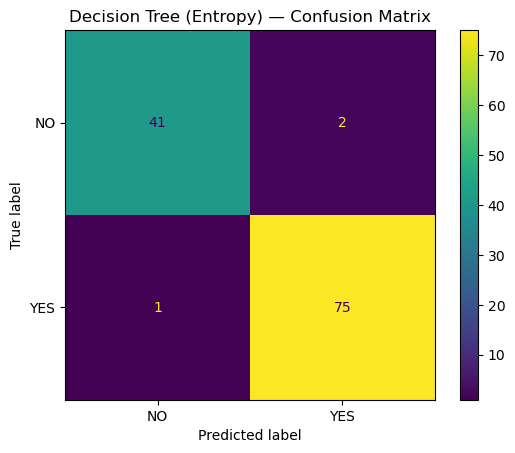


=== DecisionTree (Gini) ===
Train: 1.0 | Test: 1.0
              precision    recall  f1-score   support

          NO     1.0000    1.0000    1.0000        43
         YES     1.0000    1.0000    1.0000        76

    accuracy                         1.0000       119
   macro avg     1.0000    1.0000    1.0000       119
weighted avg     1.0000    1.0000    1.0000       119



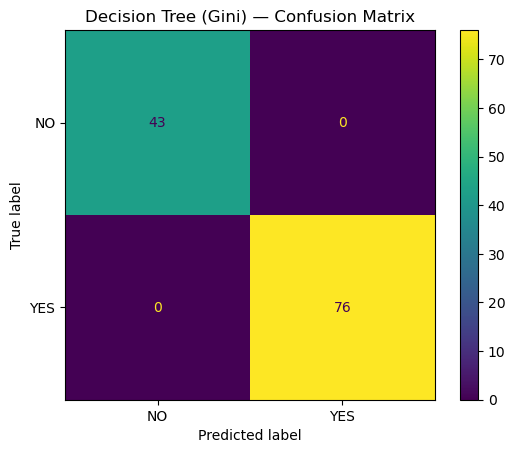

In [12]:
# 4.3 Evaluate both trees
print("=== DecisionTree (Entropy) ===")
print("Train:", entr_model.score(X_train, y_train), "| Test:", entr_model.score(X_test, y_test))
print(classification_report(y_test, y_pred_entr, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_entr)
plt.title('Decision Tree (Entropy) — Confusion Matrix')
plt.show()

print("\n=== DecisionTree (Gini) ===")
print("Train:", gini_model.score(X_train, y_train), "| Test:", gini_model.score(X_test, y_test))
print(classification_report(y_test, y_pred_gini, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gini)
plt.title('Decision Tree (Gini) — Confusion Matrix')
plt.show()


### 4.4 Pick best tree & predict unlabeled

In [13]:
# 4.4 Pick best tree & predict unlabeled rows (if any)
best_tree = gini_model if gini_model.score(X_test, y_test) >= entr_model.score(X_test, y_test) else entr_model

if len(Prediction) > 0 and len(cat + num) > 0:
    Xp = Prediction[[c for c in (cat + num) if c in Prediction.columns]].copy()
    yp = best_tree.predict(Xp)
    pred_out = Prediction.copy()
    pred_out['PredictedDecision'] = yp
    display(pred_out.head(10))
    yes = (pred_out['PredictedDecision'] == 'YES').sum()
    total = len(pred_out)
    pct = 100.0 * yes / total if total else 0.0
    print(f'Unknown predicted YES: {yes}/{total} ({pct:.2f}%)')
else:
    print('No unknown Decision rows to predict or no features present.')


,Age,Gender,num_coffeeBags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision,spent_per_week,PredictedDecision
1,24,Male,0,44,164,74035,0.520906,0,NaN,44,YES
3,20,Male,0,30,107,13166,0.932098,1,NaN,30,YES
7,24,Female,0,20,34,17425,1.193188,0,NaN,20,YES
11,24,Female,0,40,153,84803,1.655096,1,NaN,40,YES
12,21,Female,0,38,122,42338,1.714179,1,NaN,38,YES
13,16,Male,0,20,69,2928,2.099595,1,NaN,20,YES
16,38,Male,0,28,58,30707,2.719815,0,NaN,28,YES
18,29,Female,0,21,79,39950,3.496596,1,NaN,21,NO
19,31,Female,0,37,141,41792,3.657707,1,NaN,37,YES
21,23,Male,0,41,125,58390,4.206918,1,NaN,41,YES


Unknown predicted YES: 177/228 (77.63%)


# 5. Random Forest & Comparison

### 5.1 Random Forest — fit, predict, evaluate

=== RandomForest ===
Train: 1.0 | Test: 0.9663865546218487
              precision    recall  f1-score   support

          NO     0.9535    0.9535    0.9535        43
         YES     0.9737    0.9737    0.9737        76

    accuracy                         0.9664       119
   macro avg     0.9636    0.9636    0.9636       119
weighted avg     0.9664    0.9664    0.9664       119



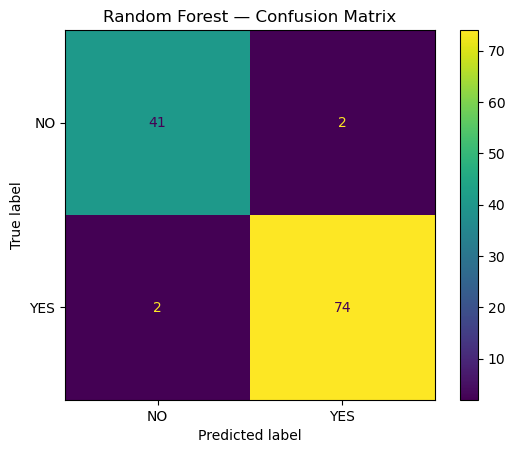

In [14]:
# 5.1 Random Forest — fit, predict, evaluate
rf_model = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=120, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print('=== RandomForest ===')
print('Train:', rf_model.score(X_train, y_train), '| Test:', rf_model.score(X_test, y_test))
print(classification_report(y_test, y_pred_rf, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Random Forest — Confusion Matrix')
plt.show()


### 5.2 Final comparison

In [15]:
# 5.2 Summary comparison (Test accuracy)
scores = {
    'DecisionTree (Entropy)': entr_model.score(X_test, y_test),
    'DecisionTree (Gini)':    gini_model.score(X_test, y_test),
    'RandomForest':           rf_model.score(X_test, y_test),
}
for k, v in scores.items():
    print(f'{k:>24}: {v:.4f}')

best_name = max(scores, key=scores.get)
print(f'\nBest overall: {best_name} ({scores[best_name]:.4f})')


  DecisionTree (Entropy): 0.9748
     DecisionTree (Gini): 1.0000
            RandomForest: 0.9664

Best overall: DecisionTree (Gini) (1.0000)
